In [2]:
import servo
import analyse
import plot

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

In [3]:
def timestamps_to_displacement(timestamped_data, velocity):

    data = (timestamped_data
            .pipe(servo.reindex_timestamps_with_times)
            .pipe(servo.calculate_displacement, velocity)
           )
    displacement_data = data.set_index("Displacement (m)")

    
    return displacement_data
    

def plot_knife_edge_method(ax, dataset):
    xs = dataset.index.values*1E3 # in mm
    ys = dataset["Power (W)"].values*1E6 # in uW
    
    coeffs, coeff_errs = analyse.fit_erf(xs, ys)
    fit_ys = analyse.erf(xs, *coeffs)

    gauss_ys = analyse.G(xs, 2*coeffs[0], coeffs[1], coeffs[2]/np.sqrt(2))

    lower_bound, upper_bound = analyse.get_e_squared_range(xs, gauss_ys)

    ax.set_xlabel("Displacement [mm]")
    
    ax.plot(xs, ys, marker='.', linestyle='', color="tab:blue", label="meas")
    ax.plot(xs, fit_ys,linestyle='--', linewidth=3, color="tab:red", label="erf fit")
    ax.plot(xs, gauss_ys, linestyle='--', linewidth=3, color="tab:purple", label="gauss fit")
    
    plot.draw_dimension_lines(ax, upper_bound, lower_bound)
    ax.vlines(lower_bound, 0, max(ys), linestyle=':', linewidth=2, color="black")
    ax.vlines(upper_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")
    plt.close()

    return upper_bound - lower_bound

def plot_result(file, velocity):
    timestamped_knife_measurements = servo.get_data(file)

    displacement_data = timestamps_to_displacement(timestamped_knife_measurements, velocity)
    
    fig, axes = plt.subplots()
    axes.set_ylabel("Power (uW)")
    diameter = plot_knife_edge_method(axes, displacement_data)

    handles, labels = axes.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.1, 0.85, 0.8, 0.1))
    #plt.tight_layout()
    return diameter

In [4]:
slow_v_d = pd.read_csv("Data/speed_1_data.txt", delimiter=",", header=1, usecols=[0,1])
velocity = analyse.get_average_velocity(slow_v_d)

NUM_OF_POINTS = 3
LENS_DISTANCES = [700, 800, 825, 850]
files = [ [f"./Data/optimalSHG/2nd/{d}/{p}.csv" for p in range(0,NUM_OF_POINTS)] for d in LENS_DISTANCES ]

diameters = [
    np.array(list(map(lambda f,v : plot_result(f,v), data, np.repeat(velocity, len(data))))) for data in files
]


def plot_beam_propagation(ax, results, ps, z0_guess, col):
    ws = results * 1E-3 / 2

    coeffs, pcov = curve_fit(analyse.beam_radius, ps, ws, p0=(45E-6, z0_guess))

    fake_ps = np.linspace(0, max(ps) + 50E-3, 1000)
    expected_ws = np.array(list(map(lambda p: analyse.beam_radius(p, 42E-6, 222.4E-3), fake_ps)))
    fit_ws = np.array(list(map(lambda p: analyse.beam_radius(p, *coeffs), fake_ps)))
    w0 = min(fit_ws)
    zR = (np.pi * (w0**2))/1550E-9
    target_zR = (20*1E-3)/(2*2.84)
    percent_diff = round(abs(target_zR - zR) / (zR + target_zR) * 100, 1)

    ax.plot(fake_ps*1E3, fit_ws*1E6, linestyle='--', c=col)
    ax.plot(ps*1E3, ws*1E6, linestyle='', marker='x', color=col)
    
    ax.set_xlabel("Beam Propagation (mm)")
    ax.set_ylabel("Beam Waist (um)")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    plt.tight_layout()

    return percent_diff



23.68515


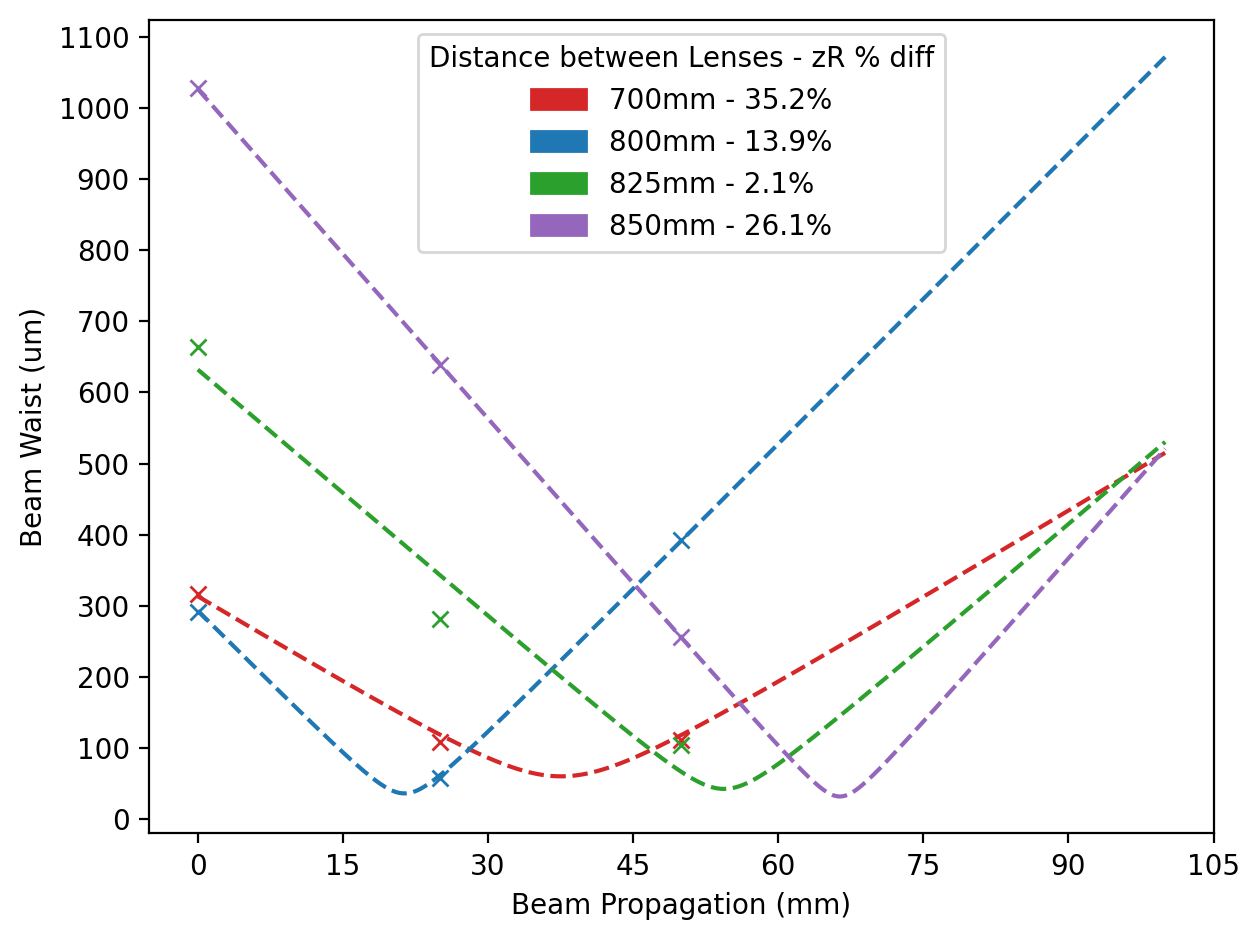

In [5]:
colours = ["tab:red", "tab:blue", "tab:green", "tab:purple"]
patches = list(map(lambda c: mpatches.Patch(color=c), colours))

fig, ax = plt.subplots(dpi=200)
ps = np.array([ 25*n for n in range(0, NUM_OF_POINTS) ]) * 1E-3
z0_guesses = [25E-3, 25E-3, 60E-3, 70E-3]

zR_percent_diffs = list(map(lambda diam, z0, c: plot_beam_propagation(ax, diam, ps, z0, c), diameters, z0_guesses, colours))
labels = list(map( lambda d, zR: f"{d}mm - {zR}%", LENS_DISTANCES, zR_percent_diffs))
ax.legend(handles=patches, labels=labels, title="Distance between Lenses - zR % diff")